## PCA for Eigenfaces

In [246]:
import cv2
import os
import os.path as osp
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['image.cmap'] = 'gray'

In [247]:
def preprocess_p2_data(dirpath='p2_data', n_persons=40, n_images=10, n_train=6, n_test=4, shuffle=False):
    # read images
    person_imgs = []
    for i in range(n_persons):
        imgs = []
        for j in range(n_images):
            imgs += [cv2.imread(osp.join(dirpath, "{:d}_{:d}.png".format(i + 1, j + 1)), 0)]
        person_imgs += [imgs]
    person_imgs = np.array(person_imgs)
    
    # split training / testing
    indices = np.arange(n_train + n_test)
    if shuffle:
        np.random.shuffle(indices)
    person_imgs_train = person_imgs[:, indices[:n_train]]
    person_imgs_test = person_imgs[:, indices[:n_test]]
    
    return person_imgs_train, person_imgs_test

In [256]:
def pca_p2_data(person_imgs, test=False):
    n_persons, n_images, h, w = person_imgs.shape
    XT_raw = person_imgs.reshape((n_persons * n_images, -1))
    XT_mean = np.mean(XT_raw, axis=0)
    XT = XT_raw - XT_mean
    
    #mean, eigen_vectors = cv2.PCACompute(XT, mean=XT_mean.reshape(1, -1), maxComponents=n_persons * n_images)
    U, Sigma, VT = np.linalg.svd(XT, full_matrices=False)
    print('XT = U * Sigma * VT:', XT.shape, U.shape, Sigma.shape, VT.shape)
    
    # 2.1
    rows, cols = 1, 5
    fig, ax = plt.subplots(rows, cols, figsize=(10, 2))
    ax[0].imshow(XT_mean.reshape((h, w)))
    ax[0].set_title("Mean Face")
    ax[0].set_xticks([]); ax[0].set_yticks([])
    for i in range(4):
        ax[i + 1].imshow(VT[i].reshape((h, w)))
        ax[i + 1].set_title("Eigenface {:d}".format(i + 1))
        ax[i + 1].set_xticks([]); ax[i + 1].set_yticks([])
    
    # test 100 eigenfaces
    if test:
        rows, cols = 10, 10
        fig, ax = plt.subplots(rows, cols, figsize=(20, 20))
        for i in range(100):
            r, c = int(i / 10), int(i % 10)
            ax[r, c].imshow(VT[i].reshape((h, w)))
            ax[r, c].set_title("{:d}".format(i + 1))
            ax[r, c].set_xticks([]); ax[r, c].set_yticks([])

    # 2.2, 2.3
    rows, cols = 1, 5
    fig, ax = plt.subplots(rows, cols, figsize=(10, 2))
    V = VT.T # eigenvectors (eigenfaces)
    original_img = XT[0]
    n_eigenfaces = [3, 45, 140, 229, len(VT)]
    for i, n in enumerate(n_eigenfaces):
        projection = np.dot(original_img, V[:, :n])
        reconstruction = np.dot(projection, VT[:n])
        mse = np.mean((original_img - reconstruction) ** 2)
        ax[i].imshow(reconstruction.reshape((h, w)))
        ax[i].set_title("n={:d}".format(n))
        ax[i].set_xticks([]); ax[i].set_yticks([])
        ax[i].set_xlabel('mse={:.2f}'.format(mse))
        
    # test all images with all eigenvectors
    if test:
        V = VT.T
        PT = np.dot(XT, V) # projection
        RT = np.dot(PT, VT) # reconstruction
        print('V:', V.shape)
        print('PT = XT * V:', PT.shape) 
        print('RT = XT * V * VT:', RT.shape)
        
    
        
    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.25, wspace=0.25)
    plt.show()
    
    

XT = U * Sigma * VT: (240, 2576) (240, 240) (240,) (240, 2576)


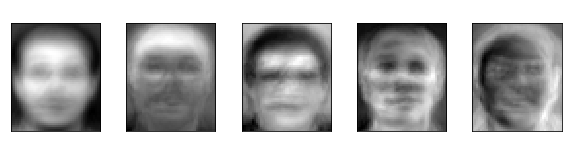

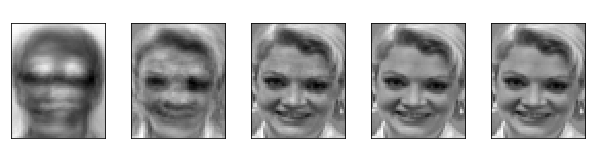

In [257]:
person_imgs_train, person_imgs_test = preprocess_p2_data()
pca_p2_data(person_imgs_train)